do a classical Monte Carlo simulation to see if atoms remain trapped in a given bottle beam potential

In [378]:
from numpy import *
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

import sys, os
sys.path.append('..\\')
sys.path.append('..\\utilities')

# local imports
from simfuncs import *
from rbconsts import *
from physconsts import *
from amophys import *

## slicing the .mat file with h5py

In [36]:
f = h5py.File('C:\\Users\\prest\\Downloads\\E_3d_after_propagation_SR.mat')
print([f[key] for key in list(f.keys())])

[<HDF5 group "/#refs#" (12 members)>, <HDF5 group "/#subsystem#" (1 members)>, <HDF5 dataset "E_3d_array_after_propagation": shape (25, 5556, 5556), type "|V16">, <HDF5 dataset "N": shape (1, 1), type "<f8">, <HDF5 dataset "x_list": shape (5556, 1), type "<f8">, <HDF5 dataset "y_list": shape (5556, 1), type "<f8">, <HDF5 dataset "z_distance_list": shape (1, 6), type "<u4">, <HDF5 dataset "z_num": shape (1, 1), type "<f8">]


In [265]:
x_list = f['x_list'][:,0]
y_list = f['y_list'][:,0]

In [116]:
f['z_distance_list'][:]

array([[3707764736,          2,          1,          1,          1,
                 1]], dtype=uint32)

In [391]:
# f['z_distance_list'][0,0]/f['z_num'][0,0]
z_list = linspace((0.9630-0.03)*1e-3,(0.963+0.03)*1e-3,int(f['z_num'][0,0]))

In [50]:
zdim,xdim,ydim = f['E_3d_array_after_propagation'].shape

In [51]:
Ez_dset = f['E_3d_array_after_propagation'][:,xdim//2,ydim//2]

In [52]:
Ez = array([Er + 1j*Ei for Er,Ei in Ez_dset])

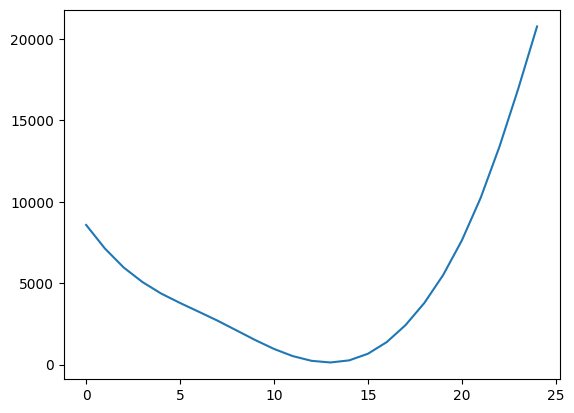

In [53]:
plt.plot(abs(Ez)**2)

In [393]:
xstart = xdim//2-40
xstop = xdim//2+40
Exz_dset = f['E_3d_array_after_propagation'][:,ydim//2,xstart:xstop]

In [394]:
Exz = array([[Er + 1j*Ei for Er,Ei in Erow] for Erow in Exz_dset])
Ixz = abs(Exz.transpose())**2

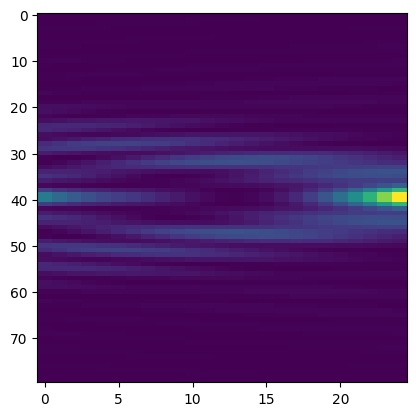

In [395]:
fig,ax = plt.subplots()
ax.imshow(Ixz)
ax.set_aspect(Ixz.shape[1]/Ixz.shape[0])

In [396]:
Exy_dset = f['E_3d_array_after_propagation'][13,xstart:xstop,xstart:xstop]
Exy = array([[Er + 1j*Ei for Er,Ei in Erow] for Erow in Exy_dset])
Ixy = abs(Exy.transpose())**2

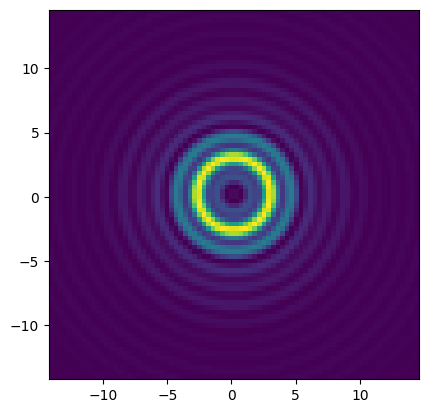

In [397]:
fig,ax = plt.subplots()
ax.imshow(Ixy, extent=[x_list[xstart]*1e6,x_list[xstop]*1e6,x_list[xstart]*1e6,x_list[xstop]*1e6])

## derive dipole force profile from the E field data - no E field interpolation

In [398]:
T_trap = 0.001 # 1 mK
Urz = kB*T_trap*Ixz[Ixz.shape[0]//2:,:]/amax(Ixz)

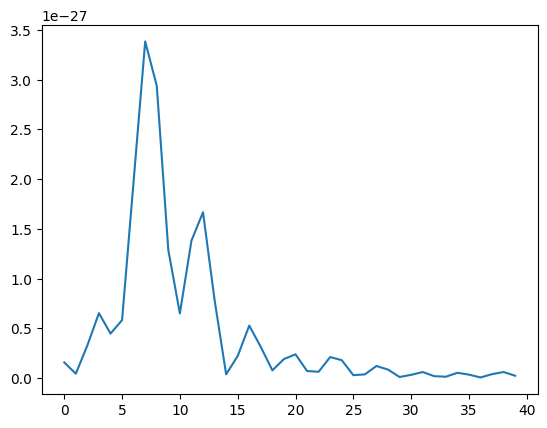

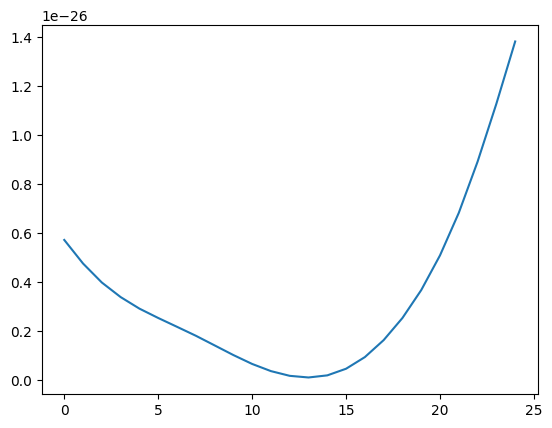

In [399]:
plt.plot(Urz[:,Urz.shape[1]//2])
plt.show()
plt.plot(Urz[0,:])
plt.show()

In [450]:
"""force is the derivative of U wrt position
Fr = dU/dr, Fz = dU/dz where d/du is the partial derivative operator
"""
dr = x_list[1] - x_list[0]
dz = z_list[1] - z_list[0]
Fr = squeeze(-1*array([[(Urz[i+1,j] - Urz[i,j])/dr for j in range(Urz.shape[1])] for i in range(Urz.shape[0]-1)]))
Fz = squeeze(-1*array([[(Urz[i,j+1] - Urz[i,j])/dz for j in range(Urz.shape[1]-1)] for i in range(Urz.shape[0])]))

# define coordinate lists to use going forward
r_list = np.linspace(0,dr*(Urz.shape[0]-1),Urz.shape[0])
z_list = np.linspace(-dr*Urz.shape[0]/2,dr*Urz.shape[0]/2,Urz.shape[1])

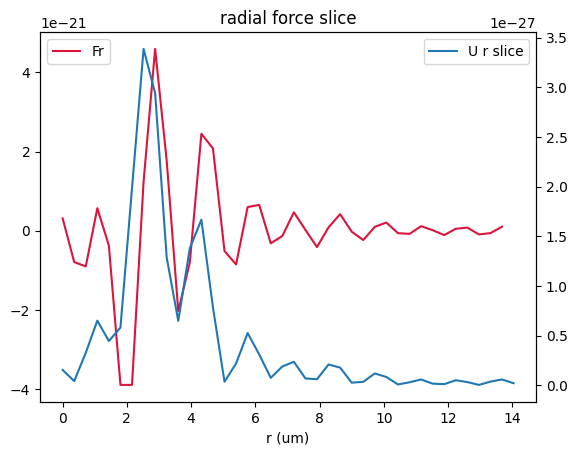

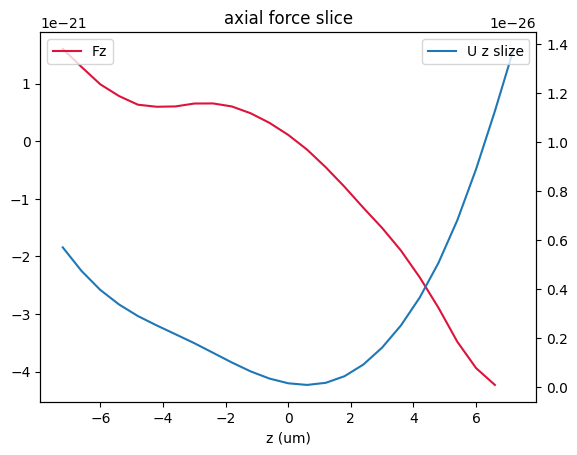

In [451]:
fig,ax = plt.subplots()
ax.plot(r_list[:-1]*1e6,Fr[:,Fr.shape[1]//2],color='crimson',label='Fr')
ax.set_title('radial force slice')
ax2 = ax.twinx()
ax2.plot(r_list*1e6,Urz[:,Urz.shape[1]//2],label='U r slice')
ax.set_xlabel('r (um)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

fig,ax = plt.subplots()
ax.plot(z_list[:-1]*1e6,Fz[0,:],color='crimson',label='Fz')
ax.set_title('axial force slice')
ax2 = ax.twinx()
ax2.plot(z_list*1e6,Urz[0,:],label='U z slize')
ax.set_xlabel('z (um)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [452]:
# interpolate the force profiles
method='cubic'
Fr_interp = RegularGridInterpolator([r_list[:-1], z_list], Fr, method=method) # Fr is valid only through the second to last r step
Fz_interp = RegularGridInterpolator([r_list, z_list[:-1]], Fz, method=method) # Fz is valid only through the second to last z step

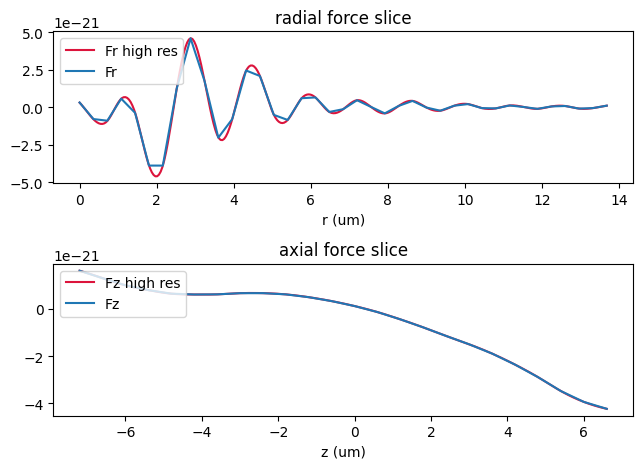

In [453]:
# sanity check to make sure the interpolated functions match the numerical derivatives

hres_pts = 300
r_list_hres = np.linspace(r_list[0],r_list[-2],hres_pts)
z_list_hres = np.linspace(z_list[0],z_list[-1],hres_pts)
fig,axes = plt.subplots(nrows=2)
ax,ax2 = axes
ax.plot(r_list_hres*1e6,Fr_interp((r_list_hres,z_list_hres[hres_pts//2])),color='crimson',label='Fr high res')
ax.plot(r_list[:-1]*1e6,Fr[:,Fr.shape[1]//2],label='Fr')

ax.set_title('radial force slice')
ax.set_xlabel('r (um)')
ax.legend(loc='upper left')

r_list_hres = np.linspace(r_list[0],r_list[-1],hres_pts)
z_list_hres = np.linspace(z_list[0],z_list[-2],hres_pts)
ax2.plot(z_list_hres*1e6,Fz_interp((r_list_hres[0],z_list_hres)),color='crimson',label='Fz high res')
ax2.plot(z_list[:-1]*1e6,Fz[0,:],label='Fz')
ax2.set_title('axial force slice')
ax2.set_xlabel('z (um)')
ax2.legend(loc='upper left')
fig.tight_layout()
plt.show()

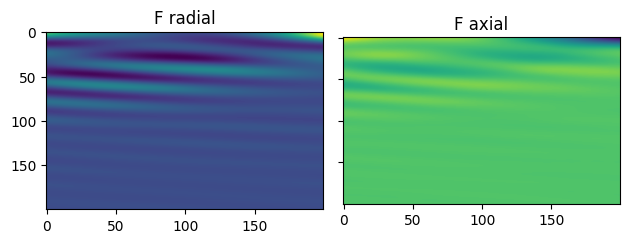

In [454]:
hres_pts = 200
r_list_hres = np.linspace(r_list[0],r_list[-2],hres_pts)
z_list_hres = np.linspace(z_list[0],z_list[-1],hres_pts)
Z, R = meshgrid(z_list_hres, r_list_hres)

fig, axes = plt.subplots(ncols=2,sharey=True)
ax,ax2 = axes
cax = ax.imshow(Fr_interp((R, Z)))
ax.set_title("F radial")
ax.set_aspect(Fr.shape[1]/Fr.shape[0])

r_list_hres = np.linspace(r_list[0],r_list[-1],hres_pts)
z_list_hres = np.linspace(z_list[0],z_list[-2],hres_pts)
Z, R = meshgrid(z_list_hres, r_list_hres)

cax = ax2.imshow(Fz_interp((R, Z)))
ax2.set_title("F axial")
ax2.set_aspect(Fz.shape[1]/Fz.shape[0])
fig.tight_layout()

## Simulate atom trajectories due to the trap forces

In [455]:
def eom_derivatives(t,state,f_radial,f_axial,m):
    """
    equation of motion derivatives
    state: a list of the state of the atom: [vx,vy,vz,x,y,z]
    f_radial: a function of positions r and z, f_radial((r,z)) which returns the force at r,z
    f_axial: a function f_axial((r,z)) which returns the force at r,z
    m: the atomic mass
    return:
     derivatives: the list of the derivatives of the state variables,
         [vrdot,vzdot,rdot,zdot]
    """
    vx,vy,vz,x,y,z = state
    theta = arctan2(y,x) # the azimuthal angle
    r = sqrt(x**2+y**2)

    try:
        vxdot = f_radial((r,z))*cos(theta)/m
        vydot = f_radial((r,z))*sin(theta)/m
        vzdot = f_axial((r,z))/m
    # the interpolating functions are only valid over a finite range, so 
    # we will get a ValueError if an atom makes its way to the edge of that range
    except ValueError as e: 
        # print("exception: {e}")
        vxdot = 0
        vydot = 0
        vzdot = 0
    xdot = vx
    ydot = vy
    zdot = vz

    derivatives = [vxdot,vydot,vzdot,xdot,ydot,zdot]
    return derivatives

# the derivatives function we will pass to the ode solver
derivs = lambda t, state: eom_derivatives(
    t, 
    state, 
    f_radial=Fr_interp, 
    f_axial=Fz_interp,
    m=mRb)

### one atom dropped in the trap

In [467]:
# T_atom = 5e-5
# n_atoms = 100
# vlist = ensemble(T_atom,n_atoms)

tdomain = [0,0.0005]
state0 = [.07,0.07,0.07,0,0,0] # [v0 [m/s] ,r0 [m]] 

soln = solve_ivp(derivs,tdomain,state0)

In [468]:
vx,vy,vz,x,y,z = soln.y

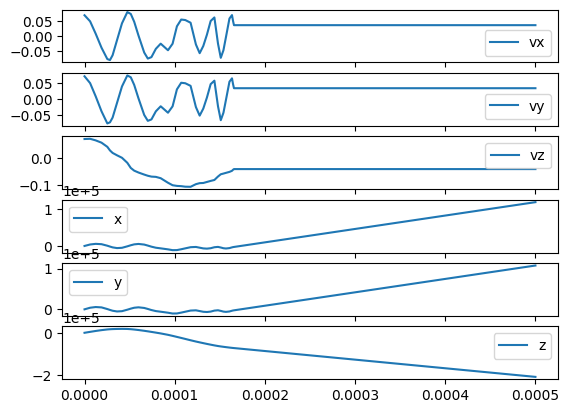

In [469]:
labels = ['vx','vy','vz','x','y','z']
fig,axes = plt.subplots(nrows=len(labels),sharex=True)
for u,ax,lbl in zip(soln.y,axes,labels):
    ax.plot(soln.t,u,label=lbl)
    ax.legend()

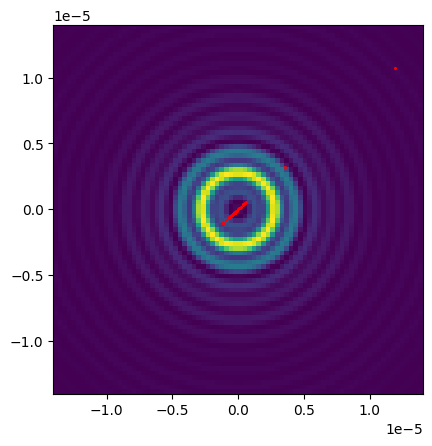

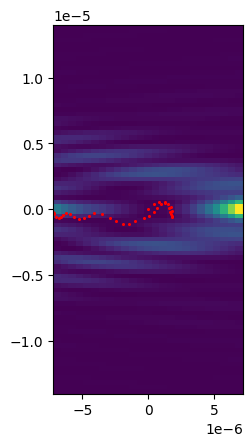

In [471]:
fig,ax = plt.subplots()
ax.imshow(Ixy, extent=[-r_list[-1],r_list[-1],-r_list[-1],r_list[-1]])
ax.scatter(x,y,s=1.5,c='r')
ax.set_xlim((-r_list[-1],r_list[-1]))
ax.set_ylim((-r_list[-1],r_list[-1]))
plt.show()
fig,ax = plt.subplots()
ax.imshow(Ixz, extent=[z_list[0],z_list[-1],-r_list[-1],r_list[-1]])
ax.scatter(z,x,s=1.5,c='r')
ax.set_xlim((z_list[0],z_list[-1]))
ax.set_ylim((-r_list[-1],r_list[-1]))
plt.show()

### an ensemble of atoms dropped in the trap

In [492]:
T_atom = 4e-5
n_atoms = 100
atoms = ensemble(T_atom)
vlist = atoms.sampling_maxboltzv(n_atoms,domain=[0,1])

# it only takes about 20 us for an atom to leak out of the trap
tdomain = [0,0.0005]

x_solns = []
y_solns = []
z_solns = []
for v in vlist:
    ax = rand()
    ay = rand()
    az = rand()
    norm = ax+ay+az
    vx = ax*v/norm
    vy = ay*v/norm
    vz = az*v/norm
    
    state0 = [vx,vy,vz,0.0,0.0,0.0] 

    soln = solve_ivp(derivs,tdomain,state0)
    x_solns.append(soln.y[3])
    y_solns.append(soln.y[4])
    z_solns.append(soln.y[5])

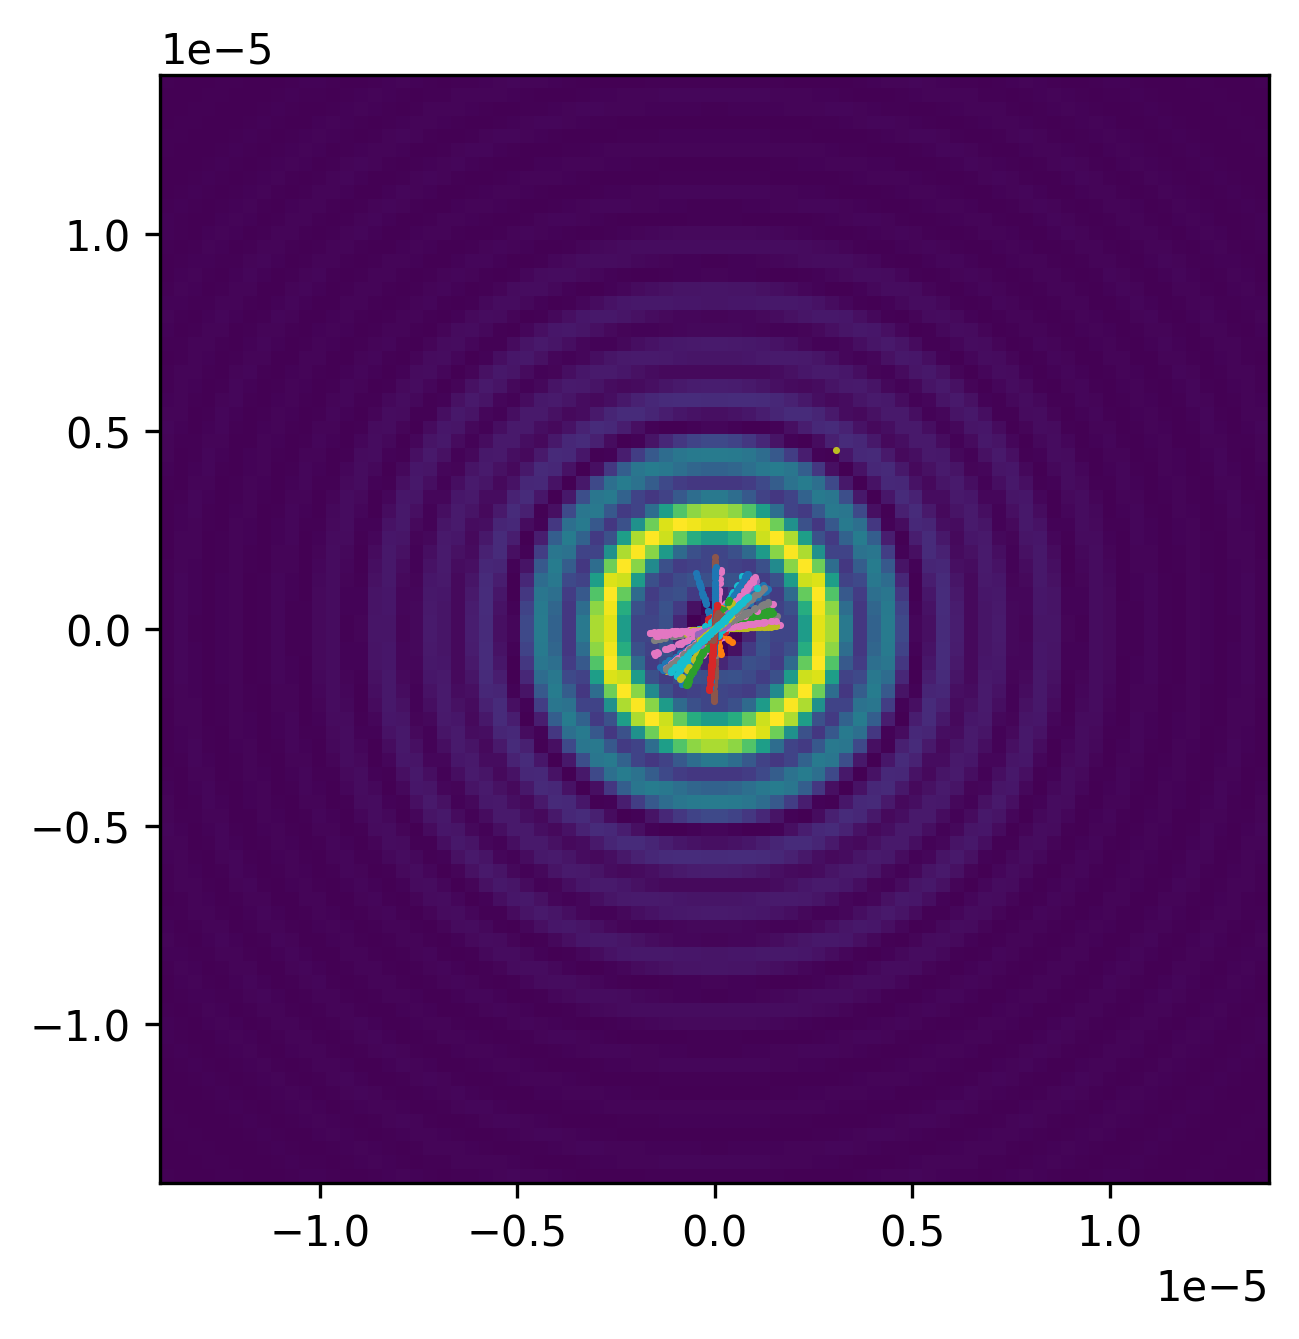

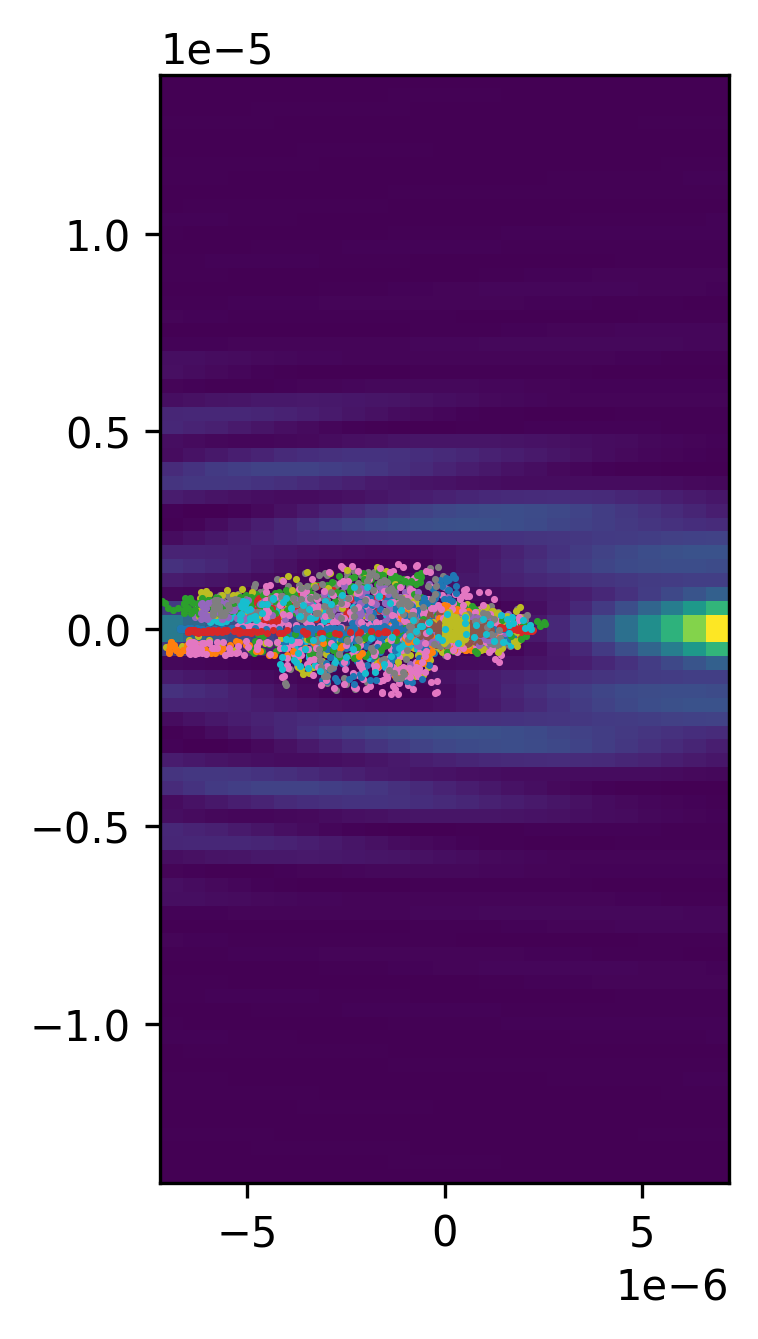

In [493]:
# note that the apparent weird behavior in the xy plot (top) below where occasionally atoms appear to have escaped the bottle -- this is of course not physical but
# shows up as a result of the way I'm handling what happens when an atom hits the "edge" of the data for the trap force profile. the acceleration in all directions 
# is set to zero if the atom hits any of the edges of the valid force range, so the atom continues unimpeded in whatever direction it was going at that moment.

fig,ax = plt.subplots(dpi=300)
ax.imshow(Ixy, extent=[-r_list[-1],r_list[-1],-r_list[-1],r_list[-1]])
for x,y in zip(x_solns,y_solns):
    ax.scatter(x,y,s=0.5)
ax.set_xlim((-r_list[-1],r_list[-1]))
ax.set_ylim((-r_list[-1],r_list[-1]))
plt.show()
fig,ax = plt.subplots(dpi=300)
ax.imshow(Ixz, extent=[z_list[0],z_list[-1],-r_list[-1],r_list[-1]])
for x,z in zip(x_solns,z_solns):
    ax.scatter(z,x,s=0.5)
ax.set_xlim((z_list[0],z_list[-1]))
ax.set_ylim((-r_list[-1],r_list[-1]))
plt.show()

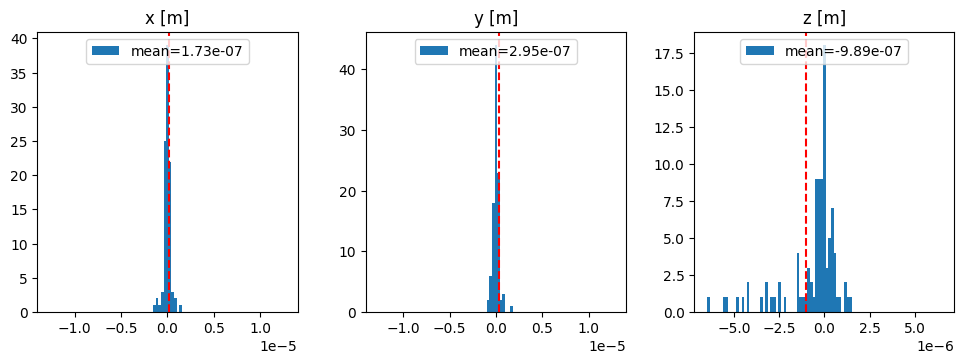

In [494]:
lastx = [u[-1] for u in x_solns]
lasty = [u[-1] for u in y_solns]
lastz = [u[-1] for u in z_solns]

# plot histograms of atom final coordinates
binz = 100
binlist = [linspace(-r_list[-1],r_list[-1],binz),linspace(-r_list[-1],r_list[-1],binz),linspace(z_list[0],z_list[-1],binz)]
labels=['x [m]','y [m]','z [m]']
fig,axes = plt.subplots(nrows=1,ncols=3,dpi=100, figsize=(10,4))
for ax,uu,bb,l in zip(axes,[lastx,lasty,lastz],binlist,labels):
    uubar = mean(uu)
    ax.hist(uu,bins=bb,label=f'mean={uubar:.2e}')
    ax.set_xlim((bb[0],bb[-1]))
    ax.axvline(uubar,color='r',ls='--')
    ax.set_title(l)
    ax.legend(loc='upper center')
fig.tight_layout(pad=2)
plt.show()